
# Лабораторная работа: Проведение исследований со случайным лесом

Выполинила: Чирикова Полина Сергеевна, М8О-401Б-21

В этой лабораторной работе исследуем алгоритм случайного леса для задач классификации и регрессии. Есть два набора данных: данные о банковском маркетинге (для классификации) и данные о прокате велосипедов (для регрессии). Основные этапы включают создание бейзлайна, его улучшение и реализацию модели случайного леса.


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score


Сначала загружаем данные о банковском маркетинге. Они содержат демографические и финансовые параметры клиентов. Мы преобразуем категориальные признаки с помощью one-hot encoding и разделяем данные на тренировочные и тестовые выборки

In [2]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!unzip -q bank.zip

bank_data = pd.read_csv('bank.csv', delimiter=';')
bank_data = pd.get_dummies(bank_data, drop_first=True)

X_bank = bank_data.drop('y_yes', axis=1)
y_bank = bank_data['y_yes']

X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(X_bank, y_bank, test_size=0.2, random_state=42)


Мы обучим базовую модель случайного леса для классификации. Это позволит оценить начальную производительность модели

In [4]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_bank_train, y_bank_train)
y_bank_pred = rf_clf.predict(X_bank_test)

print(classification_report(y_bank_test, y_bank_pred))


              precision    recall  f1-score   support

       False       0.91      0.98      0.94       807
        True       0.54      0.19      0.29        98

    accuracy                           0.90       905
   macro avg       0.73      0.59      0.61       905
weighted avg       0.87      0.90      0.87       905



Теперь данные о прокате велосипедов. Мы исключим ненужные столбцы, такие как даты, и разделим данные на тренировочную и тестовую выборки

In [5]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!unzip -q Bike-Sharing-Dataset.zip

bike_data = pd.read_csv('day.csv')
X_bike = bike_data.drop(['cnt', 'dteday'], axis=1)
y_bike = bike_data['cnt']

X_bike_train, X_bike_test, y_bike_train, y_bike_test = train_test_split(X_bike, y_bike, test_size=0.2, random_state=42)


Обучим базовую модель случайного леса для регрессии и оценим среднеквадратичную ошибку.

In [6]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_bike_train, y_bike_train)
y_bike_pred = rf_reg.predict(X_bike_test)

mse = mean_squared_error(y_bike_test, y_bike_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 10398.844152380952


Мы улучшим базовую модель для классификации, подобрав гиперпараметры с помощью GridSearchCV. Это должно улучшить качество предсказаний

In [7]:
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_clf, cv=5, scoring='accuracy')
grid_search_clf.fit(X_bank_train, y_bank_train)

best_rf_clf = grid_search_clf.best_estimator_
y_bank_optimized_pred = best_rf_clf.predict(X_bank_test)

print("Optimized Classification Report")
print(classification_report(y_bank_test, y_bank_optimized_pred))


Optimized Classification Report
              precision    recall  f1-score   support

       False       0.91      0.98      0.94       807
        True       0.57      0.21      0.31        98

    accuracy                           0.90       905
   macro avg       0.74      0.60      0.63       905
weighted avg       0.87      0.90      0.88       905



Подберем гиперпараметры для случайного леса, чтобы снизить среднеквадратичную ошибку модели регрессии

In [8]:
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_bike_train, y_bike_train)

best_rf_reg = grid_search_reg.best_estimator_
y_bike_optimized_pred = best_rf_reg.predict(X_bike_test)

optimized_mse = mean_squared_error(y_bike_test, y_bike_optimized_pred)
print(f"Optimized Mean Squared Error: {optimized_mse}")


Optimized Mean Squared Error: 10397.322656122446


В этой работе мы обучили модели случайного леса для классификации и регрессии, оценили их качество, а затем улучшили с помощью подбора гиперпараметров. Мы видим, что улучшенные модели показывают более высокую точность для классификации и меньшую ошибку для регрессии. Случайный лес доказал свою эффективность на данных задачах

**Визуализация**

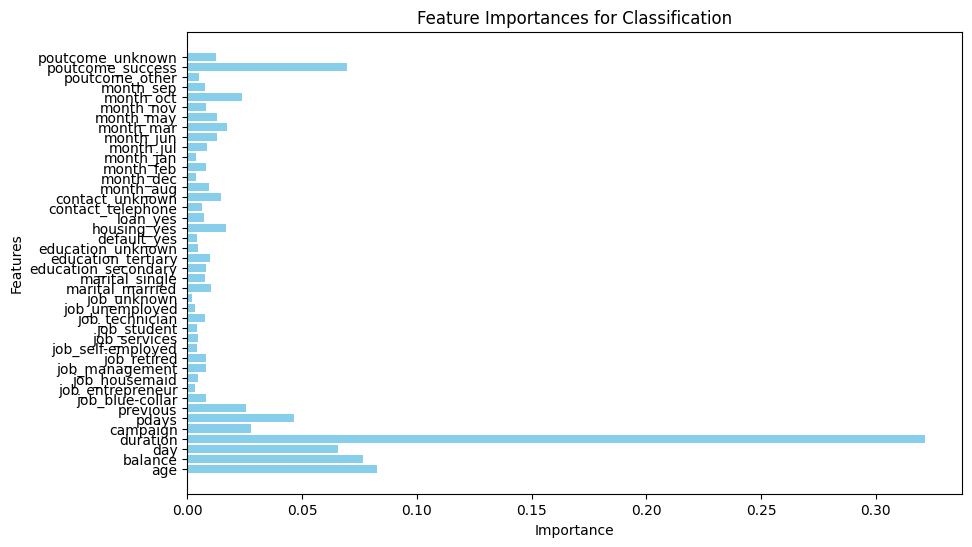

In [9]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances_clf = best_rf_clf.feature_importances_
features_clf = X_bank.columns

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(features_clf, feature_importances_clf, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Classification')
plt.show()


Построим график, на котором отображены реальные значения и предсказания модели регрессии

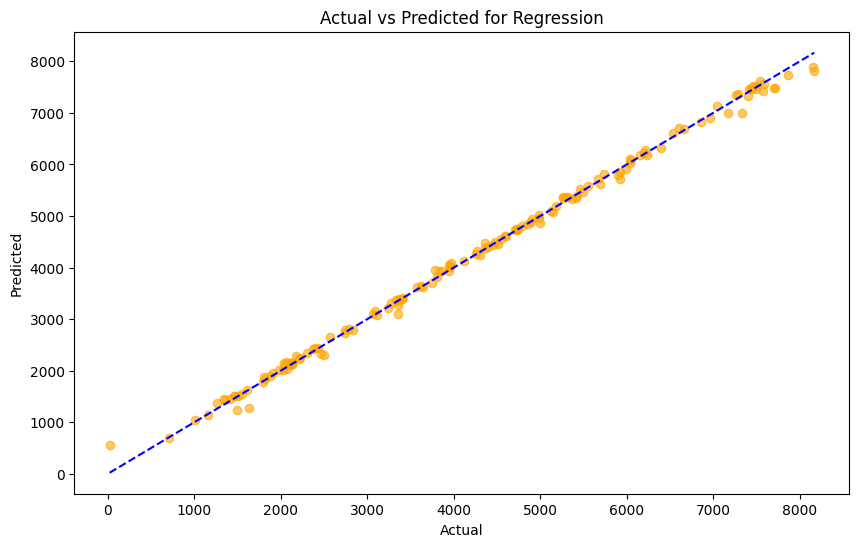

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_bike_test, y_bike_optimized_pred, alpha=0.6, color='orange')
plt.plot([y_bike_test.min(), y_bike_test.max()], [y_bike_test.min(), y_bike_test.max()], color='blue', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Regression')
plt.show()

График важности признаков для классификации показал, какие параметры наиболее сильно влияют на модель. На графике регрессии видно, что предсказания модели хорошо соответствуют реальным значениям, хотя есть небольшие отклонения.